In [5]:
import numpy as np
import pandas as pd
import cv2

import scipy
import scipy.misc

import scipy.stats as stats
from scipy.stats import kurtosis

import skimage
from skimage import filters
from skimage import data, segmentation, color
from skimage import graph
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.transform import rescale, resize, downscale_local_mean

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

(1536, 1690)


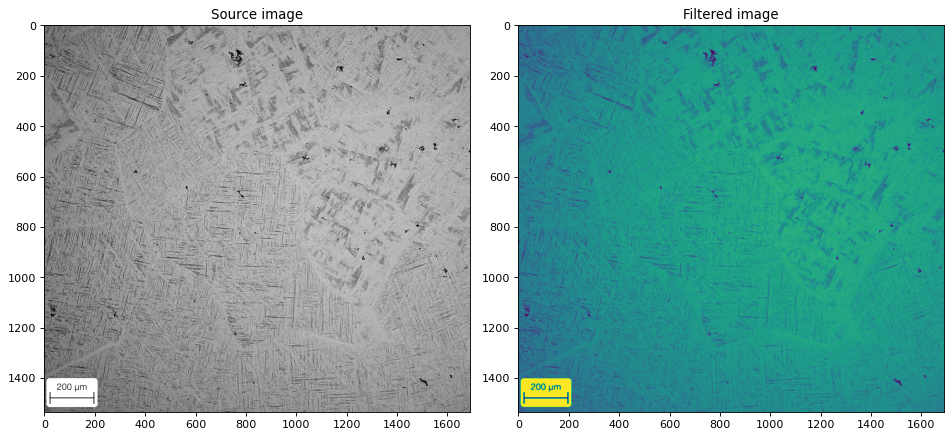

(1536, 1690)


In [24]:
# Preprocessing
src = cv2.imread(r'C:\Users\iindr\OneDrive\Documents\Engineering\Year 3 Project\MetallicAlloyMicrostructureDLAnalysis\data\Ti-6Al-4V Microstructures\797869_5x_Ti J.jpg', 0)[:,10:1700]
print(src.shape)
#blur = skimage.filters.gaussian(src, sigma=0.09) # gaussian blur
src_denoised = filters.median(src,footprint=np.ones((5,5))) # median filter

fig = plt.figure(figsize=(12,8), dpi=80)
plt.subplot(121)
plt.imshow(src,cmap='Greys_r')
plt.title('Source image')
plt.subplot(122)
plt.imshow(src_denoised)
plt.title('Filtered image')
plt.tight_layout()
plt.show()

print(src_denoised.shape)

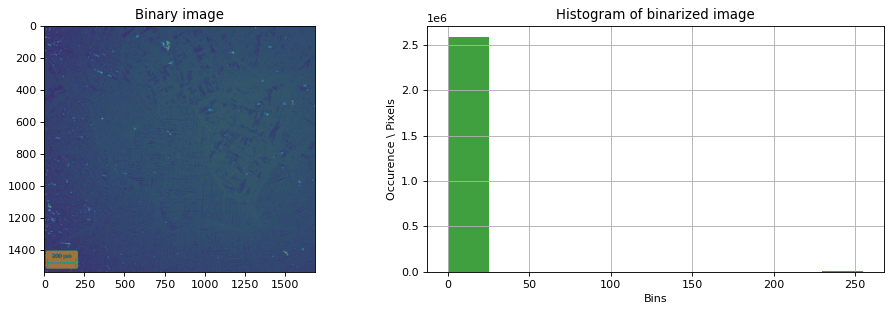


Source image area = 2595840 px

Total light area = 2584266 px2
Total dark area = 11574 px2

Fraction = 0.44786411305956897 %


In [25]:
# Image binarization to calculate areas
ret, thresh = cv2.threshold(src_denoised,60,255,cv2.THRESH_BINARY)
thresh = 255-thresh

hist, bin_edges = np.histogram(thresh.reshape(-1,1),density=False)

fig = plt.figure(figsize=(12,4), dpi=80)
plt.subplot(121)
plt.imshow(src,cmap='viridis')
plt.imshow(thresh,alpha=0.5,cmap='viridis')
plt.title('Binary image')
plt.subplot(122)
n, bins, patches = plt.hist(thresh.reshape(-1,1),10,density=False,facecolor='g',alpha=0.75)
plt.xlabel('Bins')
plt.ylabel('Occurence \ Pixels')
plt.title('Histogram of binarized image')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nSource image area = {} px".format(src.shape[0]*src.shape[1]))
print("\nTotal light area = {} px2".format(hist[0]))
print("Total dark area = {} px2".format(hist[-1]))
print("\nFraction = {} %".format(100*hist[-1]/hist[0]))

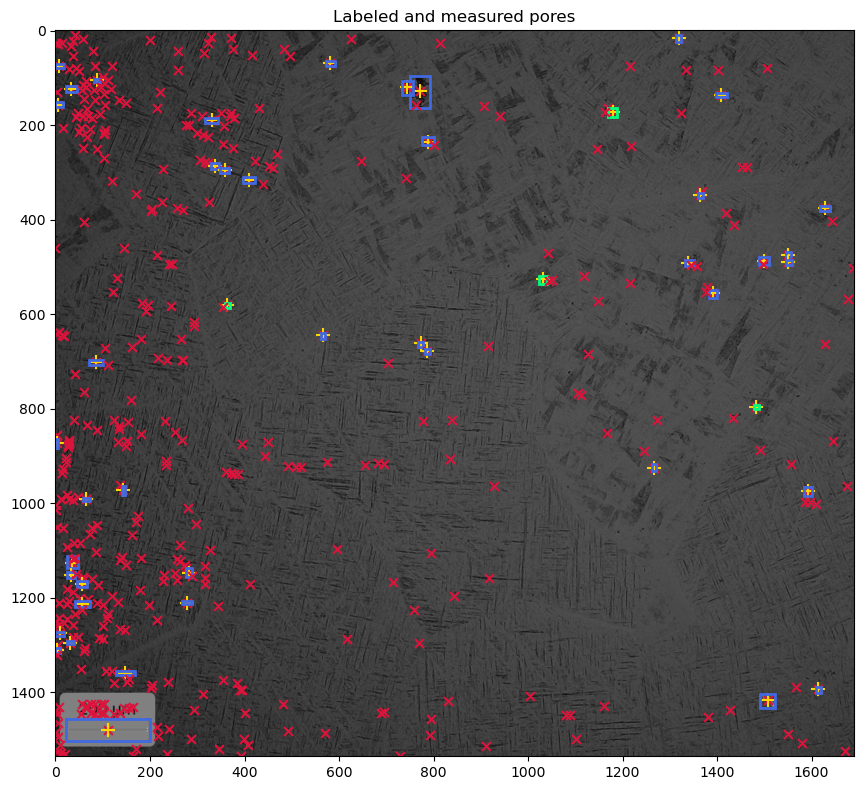

In [26]:
# Labeling and analysis of detected pores
label_image = label(thresh)
image_label_overlay = label2rgb(label_image, image=src)

MAX_AREA = 50000
MIN_AREA = 50

CRITICAL_ECCENTRICITY = 0.6

area_of_circular_pores = []
perimeter_of_circular_pores = []
equivalent_circular_diameter = []
eccentricity_of_circular_pores = []

number_of_circular_pores = 0
number_of_elliptical_pores = 0
total_number_of_pores = 0

#-----------------------------------------------------------------

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.imshow(src,cmap='gray')
ax.imshow(label_image,cmap='gray',alpha=0.5)

for region in regionprops(label_image):
    total_number_of_pores = total_number_of_pores + 1
    plt.scatter(region.centroid[1],region.centroid[0],marker='x',s=40,c='crimson')
    if (region.area <= MAX_AREA and region.area >= MIN_AREA):
        plt.scatter(region.centroid[1],region.centroid[0],marker='+',s=100,c='gold')
        minr, minc, maxr, maxc = region.bbox
        if(region.eccentricity < CRITICAL_ECCENTRICITY):
            rect = mpatches.Rectangle((minc,minr),maxc-minc,maxr-minr,
                                  fill=False, edgecolor='springgreen', linewidth=2)
            number_of_circular_pores = number_of_circular_pores + 1
            area_of_circular_pores.append(region.area)
            equivalent_circular_diameter.append(region.equivalent_diameter)
            perimeter_of_circular_pores.append(region.perimeter)
            eccentricity_of_circular_pores.append(region.eccentricity)

        else:
            rect = mpatches.Rectangle((minc,minr),maxc-minc,maxr-minr,
                                  fill=False, edgecolor='royalblue', linewidth=2)
            number_of_elliptical_pores = number_of_elliptical_pores + 1
        ax.add_patch(rect)
ax.set_title('Labeled and measured pores')

plt.tight_layout()
plt.show()

In [27]:
print("\nNumber of circular pores = {}".format(number_of_circular_pores))
print("Number of elliptical pores = {}".format(number_of_elliptical_pores))
number_of_ignored_pores = total_number_of_pores-(number_of_elliptical_pores+number_of_circular_pores)
print("Number of ignored pores = {}".format(number_of_ignored_pores))
print("\nTotal number of pores = {}".format(total_number_of_pores))


Number of circular pores = 4
Number of elliptical pores = 43
Number of ignored pores = 389

Total number of pores = 436


In [28]:
# Obtained data

print("\nTotal area of circular pores = {} px2".format(int(np.sum(area_of_circular_pores))))
print("Total perimeter of circular pores = {} px".format(int(np.sum(perimeter_of_circular_pores))))

print("\nMedian equivalent diameter of circular pores = {} px".format(int(np.median(perimeter_of_circular_pores))))
print("Mean eccentricity of circular pores = {}".format(np.round(np.mean(eccentricity_of_circular_pores),2)))


pore_area = int(np.sum(area_of_circular_pores))
image_area = src.shape[0]*src.shape[1]

print("\nPore area  = {} px2".format(pore_area))
print("Image area = {} px2".format(image_area))

print("\nPore fraction = {} %".format(100*pore_area/image_area))


Total area of circular pores = 463 px2
Total perimeter of circular pores = 194 px

Median equivalent diameter of circular pores = 48 px
Mean eccentricity of circular pores = 0.53

Pore area  = 463 px2
Image area = 2595840 px2

Pore fraction = 0.01783623027613412 %


(1536, 1690)
(153, 169)


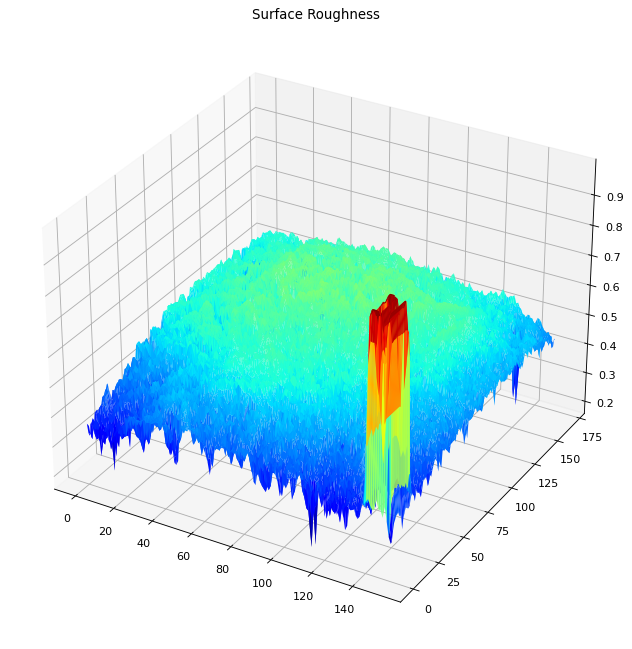

In [29]:
# Surface roughness analysis
src_resized = resize(src, (src.shape[0]//10,src.shape[1]//10),anti_aliasing=True)

print(src.shape)
print(src_resized.shape)

xx, yy = np.mgrid[0:src_resized.shape[0],0:src_resized.shape[1]]
fig = plt.figure(figsize=(14,10), dpi=80,)
ax = plt.axes(projection='3d')
ax.plot_surface(xx,yy,src_resized,rstride=1,cstride=1,cmap='jet',linewidth=1)
ax.set_title('Surface Roughness')
plt.show()

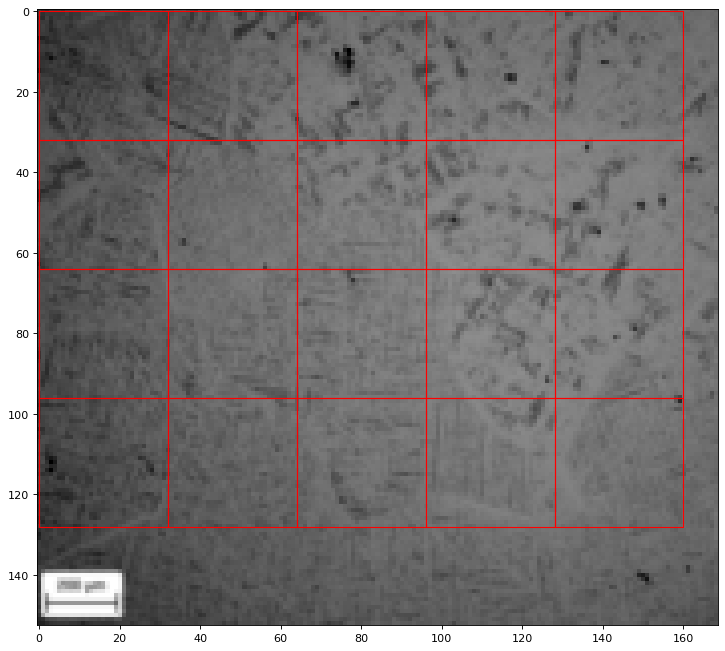

In [30]:
# Sliding window
window_size = 32

x_start = 0
x_stop = np.shape(src_resized)[1] # number of columns
y_start = 0
y_stop = np.shape(src_resized)[0] # number of rows

fig = plt.figure(figsize=(14,10), dpi=80)
ax = fig.add_subplot(111)
ax.imshow(src_resized,cmap='gray')

for i in range((int)((x_stop-x_start)/window_size)):
    for j in range((int)((y_stop-y_start)/window_size)):
        rect = mpatches.Rectangle((i*window_size,j*window_size),window_size,window_size,\
                                 linewidth=1,edgecolor='red',facecolor='none')

        ax.add_patch(rect)
plt.show()

In [31]:
hist_data = []

for i in range((int)((x_stop-x_start)/window_size)):
    for j in range((int)((y_stop-y_start)/window_size)):
        hist_data.append(src_resized[i*window_size:window_size*(i+1),\
                                     j*window_size:window_size*(j+1)])
print(np.shape(hist_data))
print("number of crops = " + str(len(hist_data)))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (20,) + inhomogeneous part.

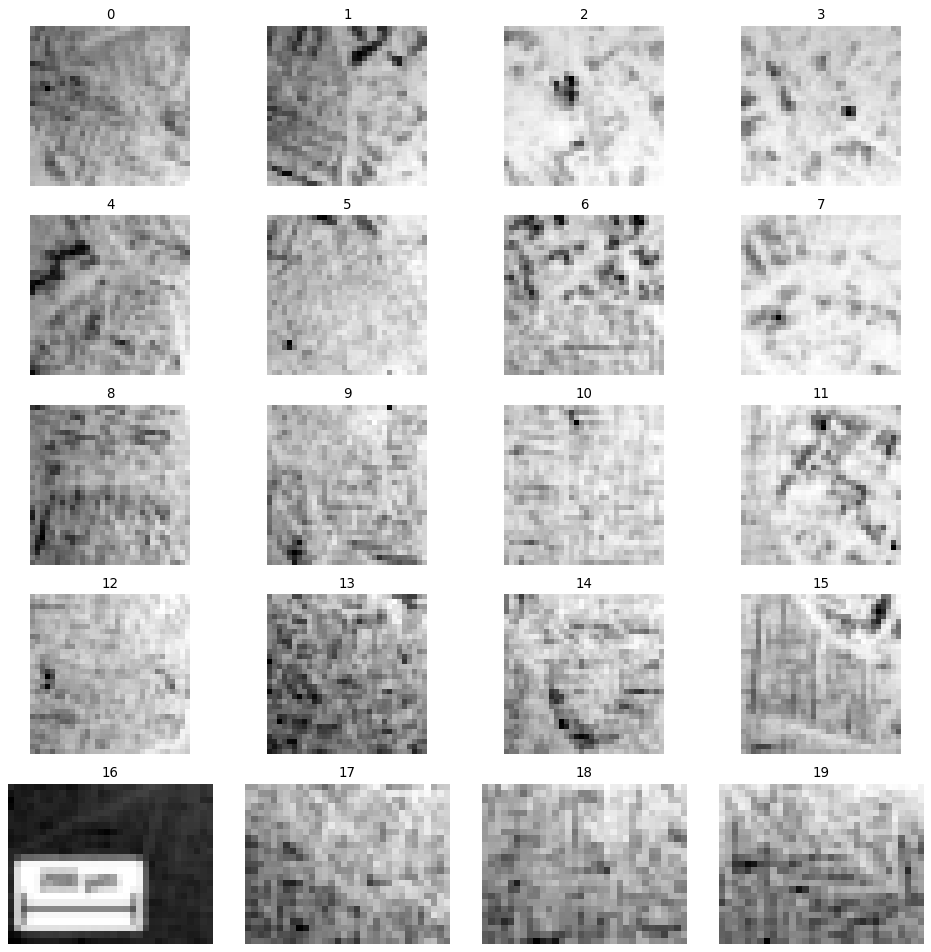

In [32]:


fig = plt.figure(figsize=(12,12), dpi=80)

for i in range(len(hist_data)):
    plt.subplot((int)((x_stop-x_start)/window_size),(int)((y_stop-y_start)/window_size),i+1)
    plt.imshow(hist_data[i], cmap='gray')
    plt.title((str)(i))
    plt.axis('off')
plt.tight_layout()
plt.show()

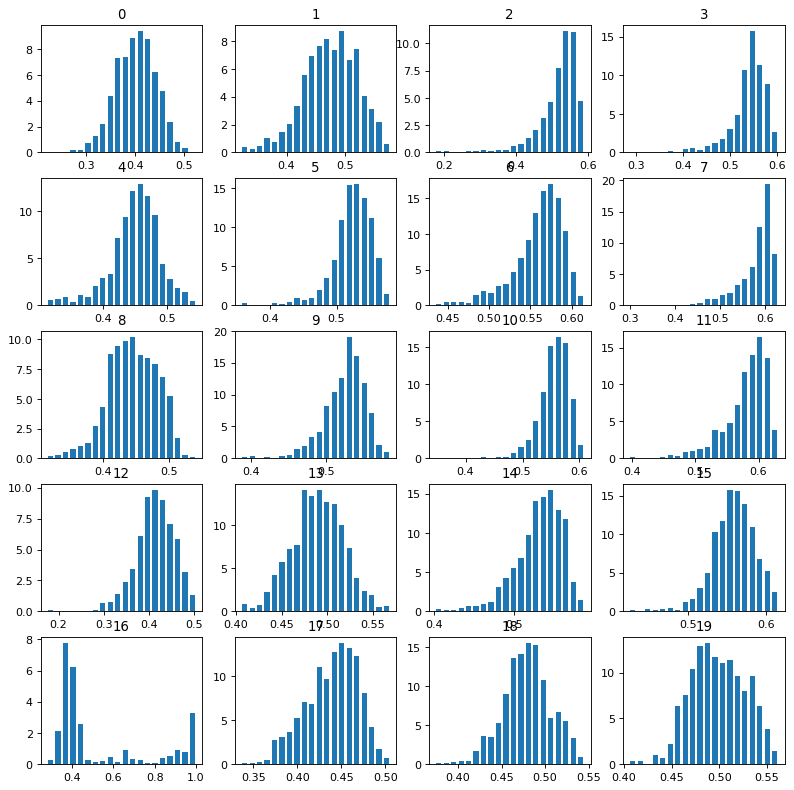

In [33]:
fig = plt.figure(figsize=(12,12), dpi=80)

for i in range(len(hist_data)):
    hist, bins = np.histogram(hist_data[i],bins=20,density=True)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.subplot((int)((x_stop-x_start)/window_size),(int)((y_stop-y_start)/window_size),i+1),

    plt.bar(center, hist, align='center', width=width),plt.title((str)(i)) # hist of the cropped rregion
plt.show()

In [34]:
mean_list = []
std_dev_list = []

for i in range(len(hist_data)):
    mean_list.append(np.mean(hist_data[i]))
    std_dev_list.append(np.std(hist_data[i]))

heat_map_mean = np.reshape(mean_list,(5, 4))
heat_map_std = np.reshape(std_dev_list,(5, 4))

(iH, iW) = heat_map_mean.shape[:2] # the same dimensions for heat_map_std
     

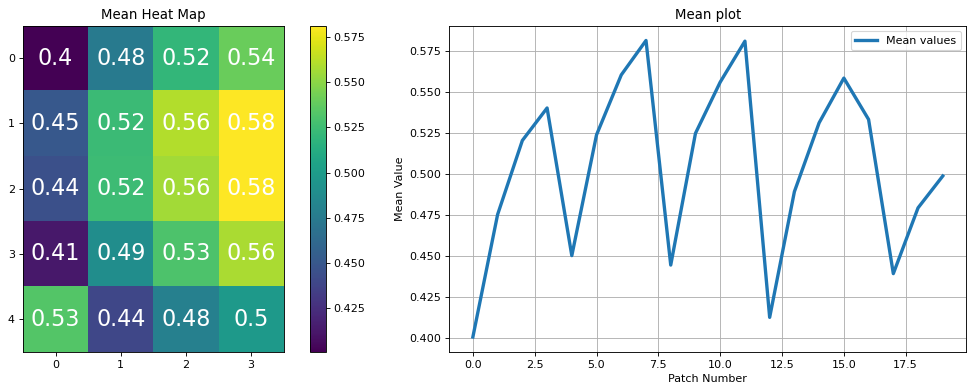

In [35]:
fig = plt.figure(figsize=(14,5), dpi=80)
plt.subplot(121)
plt.imshow(heat_map_mean),plt.colorbar()
plt.title('Mean Heat Map')
for i in range(iH):
    for j in range(iW):
        plt.text(j,i,np.round(heat_map_mean[i,j],2),ha="center",va="center",color="w",fontsize=20)

plt.subplot(122)
plt.title('Mean plot')
plt.plot(np.reshape(heat_map_mean,(iH*iW,1)),label='Mean values',linewidth=3)
plt.xlabel('Patch Number'),plt.ylabel('Mean Value')
plt.grid(),plt.legend()
plt.tight_layout()
plt.show()

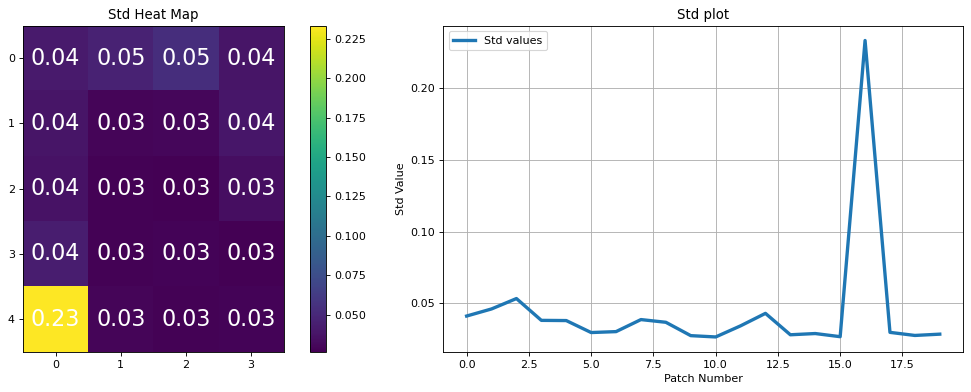

In [37]:
fig = plt.figure(figsize=(14,5), dpi=80)
plt.subplot(121)
plt.imshow(heat_map_std),plt.colorbar()
plt.title('Std Heat Map')
for i in range(iH):
    for j in range(iW):
        plt.text(j,i,np.round(heat_map_std[i,j],2),ha="center",va="center",color="w",fontsize=20)

plt.subplot(122)
plt.title('Std plot')
plt.plot(np.reshape(heat_map_std,(iH*iW,1)),label='Std values',linewidth=3)
plt.xlabel('Patch Number'),plt.ylabel('Std Value')
plt.grid(),plt.legend()
plt.tight_layout()
plt.show()

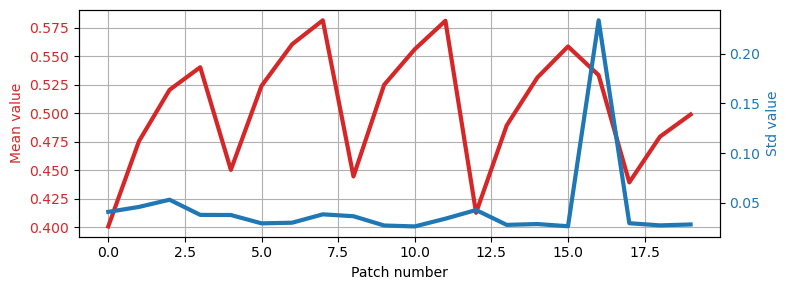

In [38]:
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(111)

color = 'tab:red'
ax1.set_xlabel('Patch number')
ax1.set_ylabel('Mean value', color=color)
ax1.plot(np.reshape(heat_map_mean,(iH*iW,1)),label='Mean values',linewidth=3,color=color)
ax1.tick_params(axis='y',labelcolor=color)
plt.grid()

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Std value', color=color)
ax2.plot(np.reshape(heat_map_std,(iH*iW,1)),label='Mean values',linewidth=3,color=color)
ax2.tick_params(axis='y',labelcolor=color)

fig.tight_layout()
#plt.grid()
plt.show()